In [326]:
# !pip install -q git+https://github.com/EfficientDL/codelab_utils.git

import pickle
import PIL
import math
import albumentations

import tensorflow as tf
import tensorflow_datasets as tfds
import codelab_utils.mpl_styles as mpl_styles
import numpy as np

from tensorflow.keras import layers, optimizers, metrics, losses, utils
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from itertools import accumulate
from functools import reduce

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

In [327]:
# Load wider_face dataset
train_ds, val_ds, test_ds = tfds.load(
    'wider_face',
    # split=['train[:80%]', 'train[80%:]', 'test'],
    split=['train[:5%]', 'validation[:5%]', 'test[:5%]'],
    # split=['train', 'validation', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

In [328]:
IMG_SIZE = 256

def resize_fn(image_shape, bboxes):
    # Resize ratios
    H, W = image_shape
    ratio_H, ratio_W = IMG_SIZE/H, IMG_SIZE/W
    bboxes = bboxes*[ratio_H, ratio_W, ratio_H, ratio_W]

    return bboxes.astype('float32')

def yxyx_to_hw_grid(boxes, grid_size):
    """
        It fits a tensor of flat boxes to a grid of given size.

        Arguments:
            boxes: A tensor of boxes in YXYX format with shape (N_BOXES, 4)
            grid_size: An integer value indicating the size of the target grid.
        
        Returns:
            A grid containing heights and widths of input boxes fitted based on their top-left coordinates.
            The output shape is (grid_size, grid_size, 2)
    """
    yx_min, yx_max = tf.split(boxes, 2, axis=-1)
    hw = yx_max - yx_min

    box_indices = yx_to_indices(yx_min, grid_size, dtype=tf.int32)
    box_grid = tf.scatter_nd(indices=box_indices, updates=hw, shape=(grid_size, grid_size, 2))
    
    return box_grid

def yx_to_indices(yx, size, dtype=tf.int64):
    return tf.cast(yx*(size - 1), dtype)

@tf.function
def preprocess_as_grid(item):
    image, boxes = item['image'], item['faces']['bbox']

    # Resize image to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    # Resize bounding boxes to IMG_SIZE
    boxes = tf.numpy_function(func=resize_fn, inp=[image.shape[:-1], boxes], Tout=tf.float32)
    boxes.set_shape([None, 4])

    # yx_min, yx_max = tf.split(bboxes, 2, axis=-1)
    # hw = yx_max - yx_min

    # box_indices = yx_to_indices(yx_min, IMG_SIZE, dtype=tf.int32)
    # box_grid = tf.scatter_nd(indices=box_indices, updates=hw, shape=(IMG_SIZE, IMG_SIZE, 2))
    box_grid = yxyx_to_hw_grid(boxes, IMG_SIZE)

    return image, box_grid

@tf.function
def filter_empty_bboxes(item):
    _, bboxes = item['image'], item['faces']['bbox']

    return tf.shape(bboxes)[0] != 0

def preprocess(item):
    image, bboxes = item['image'], item['faces']['bbox']

    # Resize image to IMG_SIZE
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    # Resize bounding boxes to IMG_SIZE
    bboxes = tf.numpy_function(func=resize_fn, inp=[image.shape[:-1], bboxes], Tout=tf.float32)
    bboxes.set_shape([None, 4])
    
    return image, tf.RaggedTensor.from_tensor(bboxes)
    # return image, tf.RaggedTensor.from_tensor([])

# train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
# train_prep_ds = train_ds.map(preprocess, num_parallel_calls=None).filter(remove_non_boxes)
# val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).filter(remove_non_boxes)
# test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_prep_ds = train_ds.filter(filter_empty_bboxes).map(preprocess_as_grid, num_parallel_calls=None)
# train_prep_ds = train_ds.filter(filter_empty_bboxes).map(preprocess_as_grid, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.filter(filter_empty_bboxes).map(preprocess_as_grid, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# bitr = iter(train_prep_ds.batch(2))
# images, bboxes = next(bitr)
# images.shape, bboxes.shape

itr = iter(train_prep_ds)
image, boxes = next(itr)
image, boxes, tf.reduce_sum(bboxes)

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.4337699 , 0.4710248 , 0.44553462],
         [0.2998545 , 0.34238663, 0.28929994],
         [0.2731771 , 0.31570926, 0.25991115],
         ...,
         [0.4492647 , 0.50944394, 0.3975337 ],
         [0.43754596, 0.48007813, 0.38777575],
         [0.44071692, 0.4708793 , 0.39215687]],
 
        [[0.437837  , 0.48097426, 0.45352328],
         [0.33871016, 0.38228402, 0.31685048],
         [0.30988052, 0.35134804, 0.26557904],
         ...,
         [0.45127144, 0.5143076 , 0.38220742],
         [0.46499693, 0.51096815, 0.3978937 ],
         [0.45882353, 0.49891236, 0.3957874 ]],
 
        [[0.4738358 , 0.5205576 , 0.48739278],
         [0.35686275, 0.40588236, 0.32386643],
         [0.3304764 , 0.37484682, 0.24700521],
         ...,
         [0.49780944, 0.5683977 , 0.40795037],
         [0.48487285, 0.54728097, 0.39876685],
         [0.47025123, 0.5287377 , 0.38431373]],
 
        ...,
 
        [[0.3017923 , 0.41910234

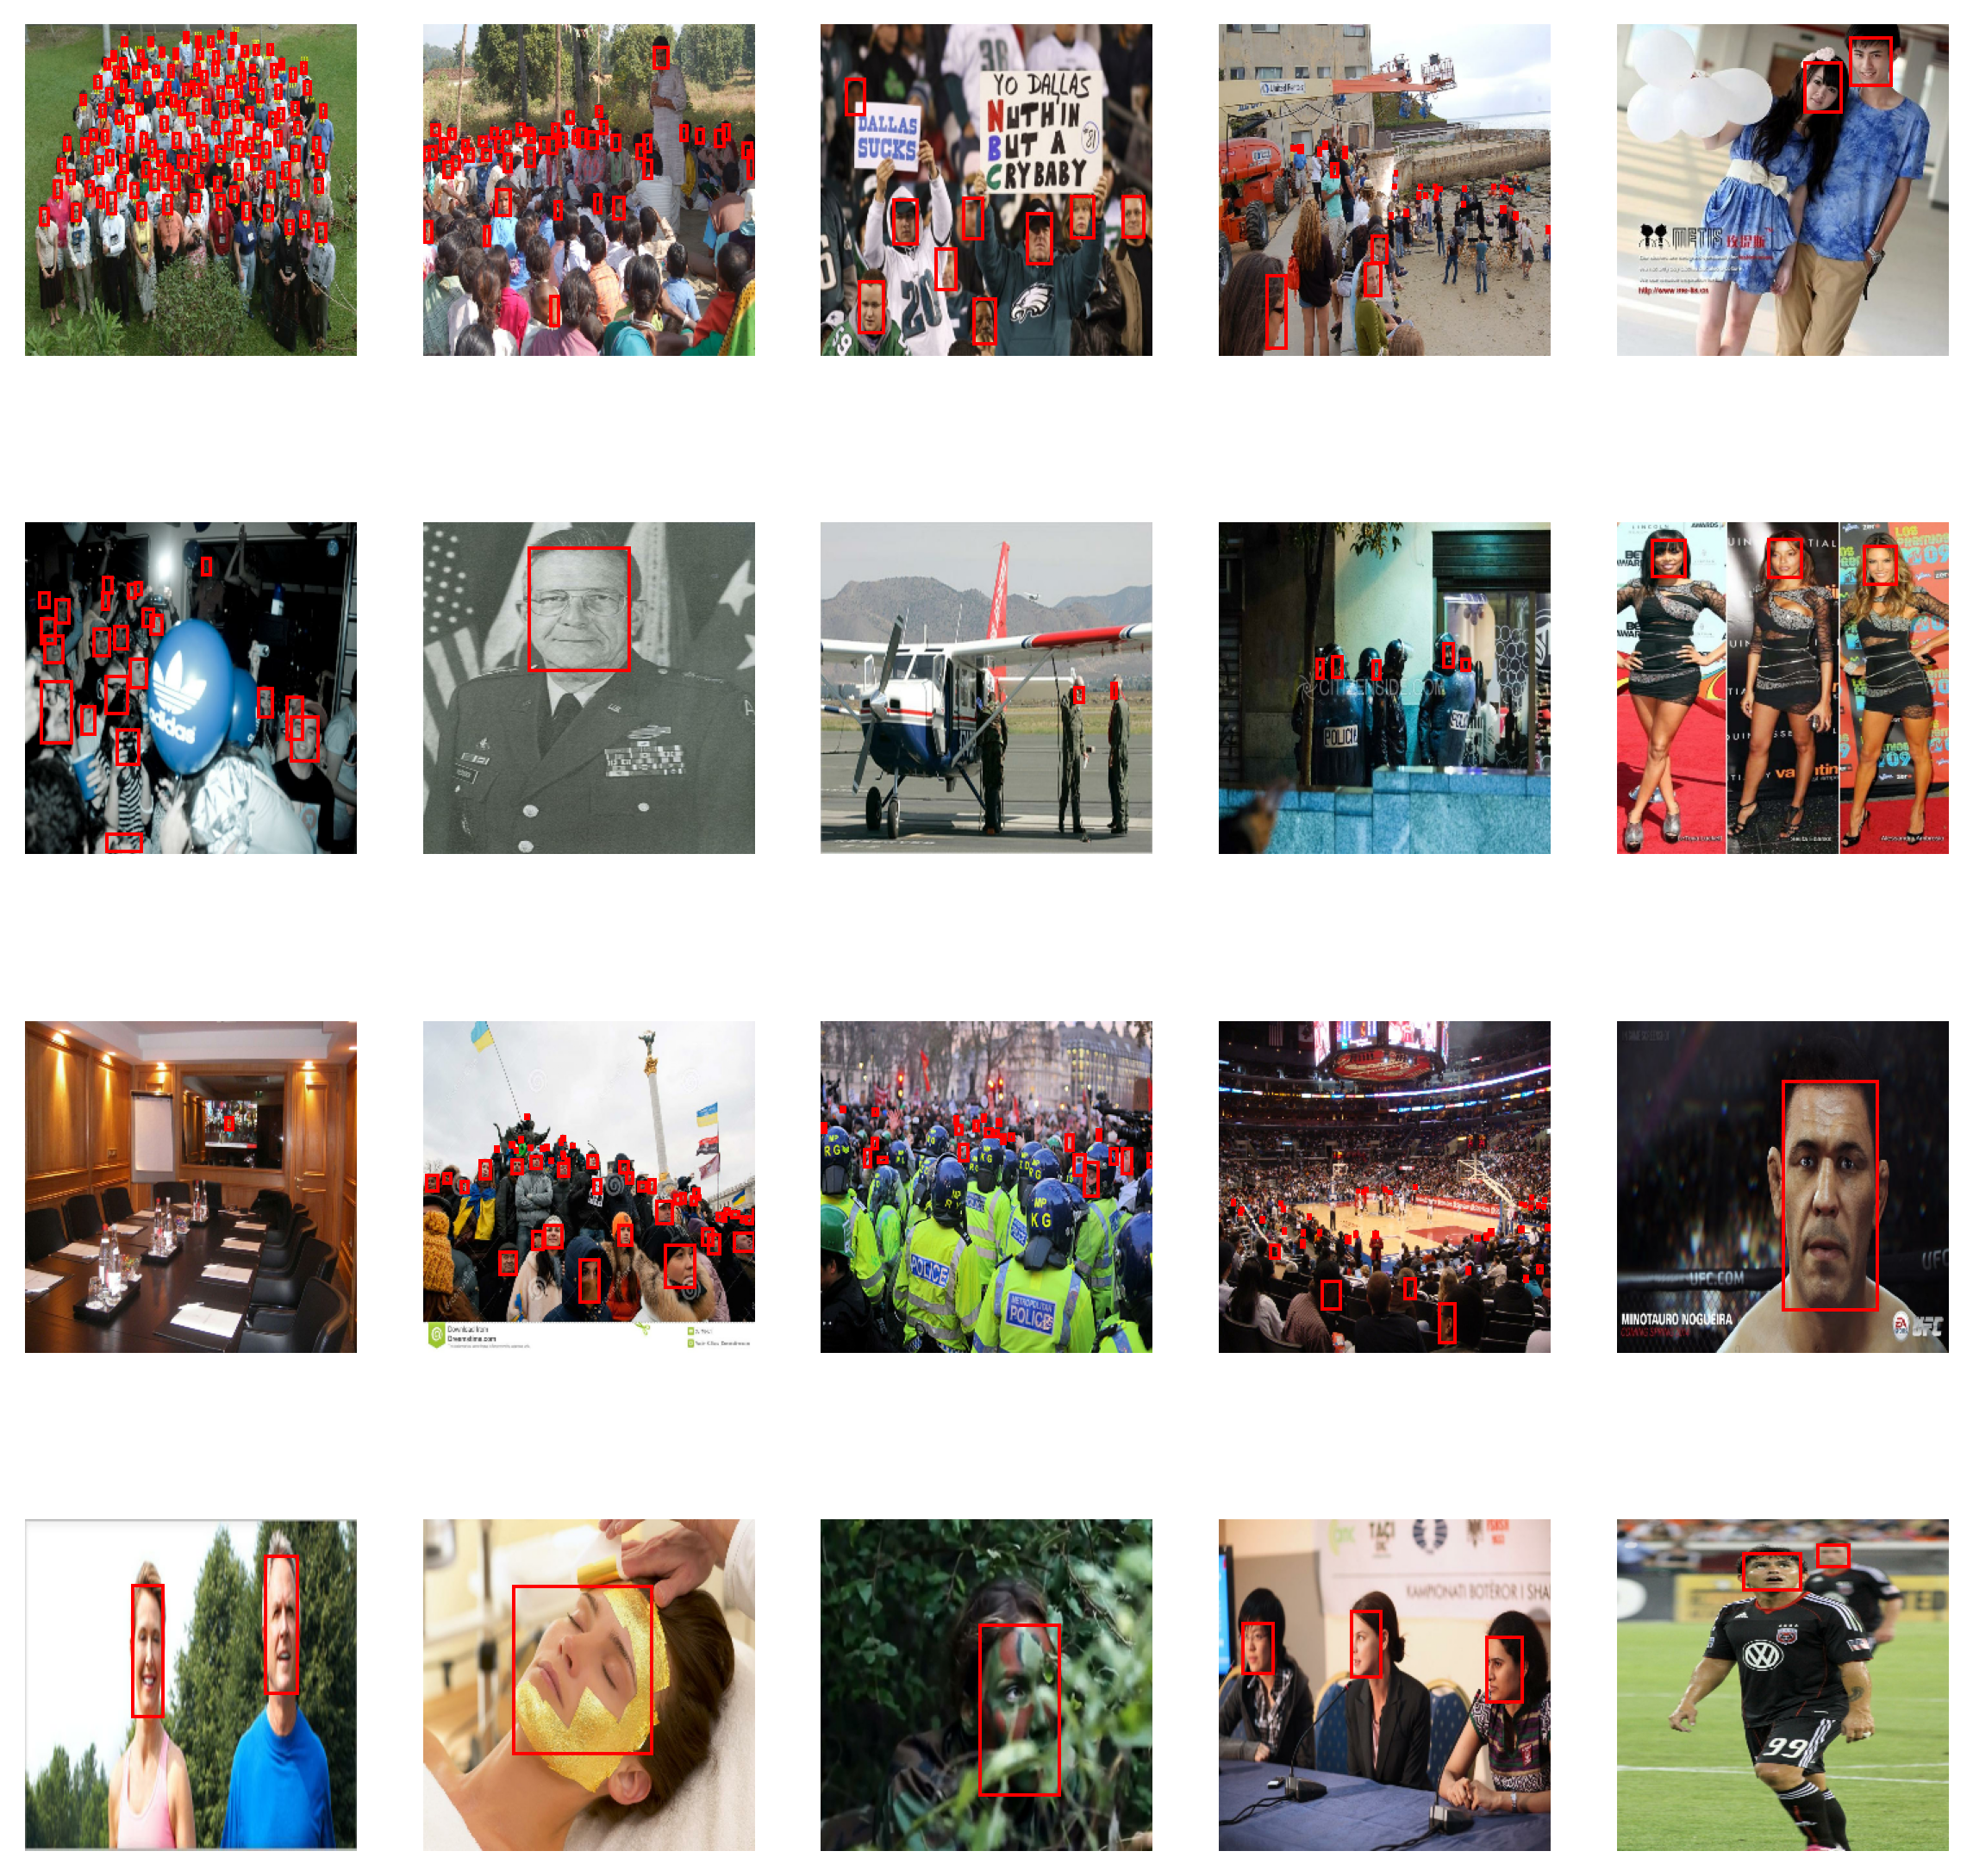

In [329]:
def bbox_to_rect(bbox, image_shape):
    image_h, image_w = image_shape
    y_min, x_min, y_max, x_max = bbox*[image_h, image_w, image_h, image_w]
    width, height = x_max-x_min, y_max-y_min
    return [x_min, y_min, width, height]

def apply_bbox(axes, bbox, image_shape):
    x_min, y_min, width, height = bbox_to_rect(bbox, image_shape)
    rect_patch = patches.Rectangle([x_min, y_min], width, height, ec='red', fc='none')

    axes.add_patch(rect_patch)

def show_input(axes, image, bboxes):
    axes.imshow(image)

    for bbox in bboxes:
        apply_bbox(axes, bbox, image.shape[:-1])

def plot_grid(items, cols=5):
    rows = (len(items)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))

    def axis_off(ax):
        ax.set_axis_off()
        return ax

    raveled_axes = list(map(axis_off, axes.ravel()))

    for index, item in enumerate(items):
        axes = raveled_axes[index]
        show_input(axes, item[0], item[1])

ds = train_ds.map(preprocess)
itr = iter(ds)
items = [next(itr) for _ in range(20)]
# items = [item]
plot_grid(items)

## Box Functions

In [330]:
def make_random_boxes(num_boxes=1):
    pair_1 = tf.random.uniform((num_boxes, 2))
    pair_2 = tf.random.uniform((num_boxes, 2))

    yx_min = tf.where(pair_1 < pair_2, pair_1, pair_2)
    yx_max = tf.where(pair_1 > pair_2, pair_1, pair_2)

    boxes = tf.concat([yx_min, yx_max], axis=-1)
    return tf.RaggedTensor.from_tensor(boxes)

def make_random_grid_boxes(num_boxes, grid_size):
    """
        Generates a random boxes in a grid.

        Arguments:
            num_boxes: An integer value to indicate the number of boxes to generate.
            grid_size: The size of target grid to fit the boxes into.
        
        Returns:
            A grid containing heights and widths of input boxes fitted based on their top-left coordinates.
            The output shape is (grid_size, grid_size, 2)
    """
    pair_1 = tf.random.uniform((num_boxes, 2))
    pair_2 = tf.random.uniform((num_boxes, 2))

    yx_min = tf.where(pair_1 < pair_2, pair_1, pair_2)
    yx_max = tf.where(pair_1 > pair_2, pair_1, pair_2)

    boxes = tf.concat([yx_min, yx_max], axis=-1)
    box_grid = yxyx_to_hw_grid(boxes, grid_size)

    # box_indices = tf.cast(tf.random.uniform((num_boxes, 2))*grid_size, dtype=tf.int32)
    # box_grid = tf.scatter_nd(indices=box_indices, updates=boxes, shape=(grid_size, grid_size, 4))

    # tf.print('box_indices: ', box_indices, box_indices.shape)
    # tf.print('boxes: ', boxes, boxes.shape)
    # tf.print('box_grid: ', box_grid, box_grid.shape)

    return box_grid

def yxyx_to_yxhw(boxes):
    """
        It translates the boxes from YXYX format to YXHW format.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in YXYX format.

        Returns:
            A tensor of boxes with shape (N_BOXES, 4) in YXHW format.
    """
    yx_min, yx_max = tf.split(boxes, 2, axis=-1)
    hw = yx_max - yx_min
    hw_boxes = tf.concat([yx_min, hw], axis=-1)
    return hw_boxes

def yxhw_to_yxyx(boxes):
    """
        It translates the boxes from YXHW format to YXYX format.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in YXHW format.

        Returns:
            A tensor of boxes with shape (N_BOXES, 4) in YXYX format.
    """
    yx_min, yx_hw = tf.split(boxes, 2, axis=-1)
    yx_max = tf.clip_by_value(yx_min + yx_hw, 0, 1)
    yxyx_boxes = tf.concat([yx_min, yx_max], axis=-1)
    return yxyx_boxes

def box_area(boxes):
    """
        It computes the area of the boxes.
        boxes: A tensor of boxes with shape (N_BOXES, 4) in YXYX format.

        Returns:
            A tensor of box areas of shape (N_BOXES, 1)
    """
    y_min, x_min, y_max, x_max = tf.split(boxes, 4, axis=-1)
    return (y_max - y_min)*(x_max - x_min)

# random_boxes = tf.map_fn(lambda v: make_random_grid_boxes(v[0], v[1]), [tf.constant([2, 3]), tf.ones((2))*4], fn_output_signature=tf.float32)

## Network Blocks

In [331]:
INITIAL_WIDTH = 64
DROPOUT_RATE = 0.6
DEBUG = False

### Attention

In [332]:
def attention_block(x, g, dims):
    """
        x: Feature map from skip connection.
        g: Feature map from the last layer. It has smaller spatial dimensions
    """

    # Transform x with strided convolution to match gating dimensions
    stride_x = x.shape[1]//g.shape[1]
    # print('Initial Shapes: ', x.shape, g.shape, stride_x)
    x_transform = layers.Conv2D(dims, 3, (stride_x, stride_x), padding="same")(x)

    # Transform g with 1x1 convolution
    g_transform = layers.Conv2D(dims, 1, padding="same")(g)

    if DEBUG:
        print('x_transform: ', x_transform.shape, 'g_transform: ', g_transform.shape)

    # Combine transformed x and g and transform them to a single channel output
    # which will be used to scale the input x. A sigmoid function is applied
    # to the comination to ensure scaling factors in range [0,1)
    x_g_combined = layers.Activation('relu')(x_transform + g_transform)
    x_g_collapsed = layers.Conv2D(1, 1, padding='same', activation="relu")(x_g_combined)

    # Match the computed weights to the input x.
    attention_weights = layers.UpSampling2D((stride_x, stride_x))(x_g_collapsed)
    attention_weights = tf.repeat(attention_weights, x.shape[-1], axis=-1)
    
    if DEBUG:
        print('attention_weights: ', attention_weights.shape)

    # Scale input x with attention
    scaled_x = attention_weights * x

    # Apply another convolution to compute the output
    output = layers.Conv2D(x.shape[-1], 1, padding='same')(scaled_x)
    output = layers.BatchNormalization()(output)

    if DEBUG:
        print('attention_block: ', output.shape)
        
    return output

# x = tf.random.normal((1, 32, 32, 64))
# g = tf.random.normal((1, 16, 16, 128))

# attention_block(x, g, 32)

### Encoder and Decoder

In [333]:
def encoder_block(input, width_multiplier, name='block'):
    conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(input)
    conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(conv_1)
    normalization = layers.BatchNormalization()(conv_2)
    pool = layers.MaxPooling2D((2, 2))(normalization)
    dropout = layers.Dropout(DROPOUT_RATE)(pool)

    if DEBUG:
        print(name, input.shape, conv_1.shape, conv_2.shape, pool.shape)

    return dropout

def central_crop(x, target_size):
    current_size = x.shape[1]
    extra_size = current_size - target_size
    start = extra_size//2
    end = start+target_size
    return x[:, start:end, start:end, :]

def decoder_block(input, skip_input, width_multiplier, name='block'):
    # Apply attention to the skip input
    attended_skip_input = attention_block(skip_input, input, INITIAL_WIDTH*width_multiplier)

    conv_transpose = layers.Conv2DTranspose(
        INITIAL_WIDTH*width_multiplier, (3, 3), strides=(2, 2), padding='same')(input)

    cropped_skip_input = central_crop(attended_skip_input, conv_transpose.shape[1])
    conv_input = layers.Concatenate()([conv_transpose, cropped_skip_input])

    conv_1 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(conv_input)
    conv_2 = layers.Conv2D(INITIAL_WIDTH*width_multiplier,
                           (3, 3), activation="relu", padding="same")(conv_1)
    normalization = layers.BatchNormalization()(conv_2)
    
    dropout = layers.Dropout(DROPOUT_RATE)(normalization)
    # dropout = layers.Dropout(DROPOUT_RATE)(conv_2)

    if DEBUG:
        print(name, conv_input.shape, conv_1.shape, conv_2.shape)

    return dropout

### Loss Function

- [x] Compute box and non-box losses separately. 

In [334]:
@tf.function
def compute_item_hw_loss(bboxes, predictions):
    """
        bboxes: A tensor of boxes with shape (IMG_SIZE, IMG_SIZE, 2)
        The last dimension contains heights and widths of the boxes.

        predictions: A tensor of boxes with shape (IMG_SIZE, IMG_SIZE, 2)
        The last dimension contains heights and widths of the boxes.

        Returns:
            * Box Loss
            * Box Count
            * Non-box Loss
            * Non-box Count
    """
    # The box_count refers to the total number of boxes. We normalize with box_count
    # which automatically weighs box_loss 2X because it combines both H and W.
    box_mask = tf.cast(tf.math.reduce_all(tf.math.not_equal(bboxes, 0.), axis=-1, keepdims=True), tf.float32)
    box_predictions = box_mask*predictions
    box_loss = tf.math.reduce_sum(tf.math.abs(bboxes - box_predictions))
    box_count = tf.math.reduce_sum(box_mask)

    # display('box_mask', box_mask)
    # display('box_predictions', box_predictions)
    # display('box_loss', box_loss)
    # display('box_count', box_count)

    non_box_mask = 1 - box_mask
    non_box_predictions = non_box_mask*predictions
    non_box_loss = tf.math.reduce_sum(non_box_predictions)
    non_box_count = tf.math.reduce_sum(non_box_mask)

    # display('non_box_mask', non_box_mask)
    # display('non_box_predictions', non_box_predictions)
    # display('non_box_loss', non_box_loss)
    # display('non_box_count', non_box_count)

    return [box_loss, box_count, non_box_loss, non_box_count]

def compute_hw_loss(y_true, y_pred):
    box_loss, box_count, non_box_loss, non_box_count = 0., 0., 0., 0.
    batch_size = tf.shape(y_true)[0]
    y_pred_hw = y_pred[:, :, :, :2]

    for item_id in range(batch_size):
        result  = compute_item_hw_loss(y_true[item_id], y_pred_hw[item_id])
        item_box_loss, item_box_count, item_non_box_loss, item_non_box_count = result
        box_loss, box_count = box_loss + item_box_loss, box_count + item_box_count
        non_box_loss, non_box_count = non_box_loss + item_non_box_loss, non_box_count + item_non_box_count
    
    mean_box_loss = box_loss / box_count
    mean_non_box_loss = non_box_loss / non_box_count
    loss = mean_box_loss + mean_non_box_loss

    # tf.print('box_loss: ', box_loss, ' box_count: ', box_count)
    # tf.print('non_box_loss: ', non_box_loss, ' non_box_count: ', non_box_count)
    # tf.print('mean_box_loss: ', mean_box_loss)
    # tf.print('mean_non_box_loss: ', mean_non_box_loss)
    # tf.print('loss: ', loss)

    return loss, mean_box_loss, mean_non_box_loss

compute_hw_loss.__name__ = 'loss'

y_true = tf.map_fn(lambda v: make_random_grid_boxes(v[0], v[1]), [tf.constant([2, 3]), tf.ones((2))*4], fn_output_signature=tf.float32)
y_pred = tf.random.uniform((2, 4, 4, 2))
# y_true = tf.map_fn(lambda v: make_random_grid_boxes(v[0], v[1]), [tf.constant([4]), tf.ones((1))*4], fn_output_signature=tf.float32)
# y_pred = tf.random.uniform((1, 4, 4, 2))
display('y_true', y_true[0])
display('y_pred', y_pred[0])
compute_hw_loss(y_true, y_pred)

2023-04-22 15:56:24.861721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


'y_true'

<tf.Tensor: shape=(4, 4, 2), dtype=float32, numpy=
array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.03137839, 0.07250178],
        [0.14944792, 0.53735065],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]]], dtype=float32)>

'y_pred'

<tf.Tensor: shape=(4, 4, 2), dtype=float32, numpy=
array([[[0.31179297, 0.8263413 ],
        [0.6849456 , 0.0067091 ],
        [0.78749514, 0.3906511 ],
        [0.29263055, 0.99216926]],

       [[0.95810425, 0.55623317],
        [0.16466296, 0.13445711],
        [0.13229859, 0.5348098 ],
        [0.57090175, 0.50970507]],

       [[0.48252344, 0.15580535],
        [0.3703227 , 0.49210668],
        [0.567016  , 0.2077086 ],
        [0.18223882, 0.99883735]],

       [[0.36950588, 0.37927854],
        [0.7723117 , 0.68211746],
        [0.39932835, 0.7840713 ],
        [0.67880154, 0.73395896]]], dtype=float32)>

2023-04-22 15:56:25.138285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(<tf.Tensor: shape=(), dtype=float32, numpy=1.9714792>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9142829>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0571963>)

### Metrics

In [335]:
class Mean(metrics.Metric):
    def __init__(self, name="mean", **kwargs):
        super(Mean, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total_{}'.format(name), initializer="zeros")
        self.count = self.add_weight(name='count_{}'.format(name), initializer="zeros")

    def update_state(self, result):
        self.total.assign_add(result)
        self.count.assign_add(1)

    def result(self):
        return self.total/self.count

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.total.assign(0.0)
        self.count.assign(0)

class History(object):
    def __init__(self):
        self.metrics = dict(
            loss = Mean(name='loss'),
            val_loss = Mean(name='val_loss'),

            box_loss = Mean(name='box_loss'),
            val_box_loss = Mean(name='val_box_loss'),

            non_box_loss = Mean(name='non_box_loss'),
            val_non_box_loss = Mean(name='val_non_box_loss'),

            iou = Mean(name='iou'),
            val_iou = Mean(name='val_iou'),
        )
        self.history = {name: [] for name, metric in self.metrics.items()}
    
    @property
    def metric_names(self):
        return list(self.metrics.keys())

    @property
    def training_metrics_names(self):
        return list(filter(lambda name: not name.startswith('val_'), self.metrics.keys()))
    
    @property
    def training_metrics(self):
        return [(name, self.metrics[name].result()) for name in self.training_metrics_names]

    @property
    def metric_values(self):
        return [(name, metric.result()) for name, metric in self.metrics.items()]
    
    def train_step(self, loss, box_loss, non_box_loss, iou):
        self.metrics['loss'].update_state(loss)
        self.metrics['box_loss'].update_state(box_loss)
        self.metrics['non_box_loss'].update_state(non_box_loss)

        self.metrics['iou'].update_state(iou)

        return self.training_metrics
    
    def val_step(self, loss, box_loss, non_box_loss, iou):
        self.metrics['val_loss'].update_state(loss)
        self.metrics['val_box_loss'].update_state(box_loss)
        self.metrics['val_non_box_loss'].update_state(non_box_loss)

        self.metrics['val_iou'].update_state(iou)

        return self.metric_values
    
    def epoch(self):
        # Record the current epoch values before reset.
        values = self.metric_values

        for name in self.metrics.keys():
            self.record_and_reset(name)
        
        return values
    
    def record_and_reset(self, name):
        self.history[name].append(self.metrics[name].result().numpy())
        self.metrics[name].reset_state()

In [336]:
IOU_EPSILON = 0.0000000000001/(IMG_SIZE*IMG_SIZE)

def compute_iou(boxes_1, boxes_2):
    """
        It computes the IoU of boxes in boxes_1 with the corresponding boxes in boxes_2.
        A negative IoU is a measure of the non-overlap between the corresponding boxes.
        boxes_1: A tensor of boxes with shape (N_BOXES, 4) in YXYX format.
        boxes_2: A tensor of boxes with shape (N_BOXES, 4) in YXYX format.

        Returns:
            A tuple of:
            * Intersections of boxes in boxes_1 and boxes_2 in YXHW format. Shape: (N_BOXES, 4)
            * IoUs of shape (N_BOXES, 1)
    """
    [b1_yx_min, b1_yx_max] = tf.split(boxes_1, 2, axis=-1)
    [b2_yx_min, b2_yx_max] = tf.split(boxes_2, 2, axis=-1)

    # Pick maximum yx_min and minimum yx_max to get the intersection
    yx_min = tf.where(b1_yx_min > b2_yx_min, b1_yx_min, b2_yx_min)
    yx_max = tf.where(b1_yx_max < b2_yx_max, b1_yx_max, b2_yx_max)

    intersection_yxyx = tf.concat([yx_min, yx_max], axis=-1)
    intersection_yxhw = yxyx_to_yxhw(intersection_yxyx)

    # Compute intersection height and width
    y_min, x_min = tf.split(yx_min, 2, axis=-1)
    y_max, x_max = tf.split(yx_max, 2, axis=-1)
    intersection_h, intersection_w = y_max - y_min, x_max - x_min

    # Record negative heights and widths. We'll force a negative area
    # if both of them are negative.
    negative_h_intersection = intersection_h < 0
    negative_w_intersection = intersection_w < 0
    negative_hw_intersection = tf.math.logical_and(negative_h_intersection, negative_w_intersection)

    # Compute intersection and union and use them to compute
    # IoUs
    intersection = tf.where(negative_hw_intersection, intersection_h*-intersection_w, intersection_h*intersection_w)
    b1_area, b2_area = box_area(boxes_1), box_area(boxes_2)
    union = b1_area + b2_area - intersection
    iou = intersection/(union + IOU_EPSILON)

    return intersection_yxhw, iou

def evaluate_boxes(boxes, predictions):
    boxes = boxes.to_tensor()
    size = predictions.shape[0]

    boxes_yx_min = boxes[:, :2]
    yx_min_indices = yx_to_indices(boxes_yx_min, size)

    # tf.print('boxes_yx_min: ', boxes_yx_min, boxes_yx_min.shape)
    # tf.print('yx_min_indices: ', yx_min_indices, yx_min_indices.shape)

    hw_preds = tf.gather_nd(predictions, yx_min_indices)[:, :2]
    yxhw_preds = tf.concat([boxes_yx_min, hw_preds], axis=-1)
    yxyx_preds = yxhw_to_yxyx(yxhw_preds)

    # tf.print('hw_preds: ', hw_preds, hw_preds.shape)
    # tf.print('yxhw_preds: ', yxhw_preds, yxhw_preds.shape)

    yxhw_intersection, iou = compute_iou(boxes, yxyx_preds)

    return yxhw_preds, yxhw_intersection, iou

def evaluate_predictions(y_true, y_pred):
    batch_size = tf.shape(y_true)[0]

    yxhw_intersections = []
    yxhw_preds = []
    ious = []

    for item_id in range(batch_size):
    # item_id = 0
        yxhw_pred, yxhw_intersection, iou = evaluate_boxes(y_true[item_id], y_pred[item_id])
        
        yxhw_intersections.append(yxhw_intersection)
        yxhw_preds.append(yxhw_pred)
        ious.append(iou)
    
    mean_iou = tf.reduce_mean(tf.concat(ious, axis=0))

    # tf.print('mean_iou: ', mean_iou)
    
    return yxhw_preds, yxhw_intersections, mean_iou

# y_pred = tf.random.uniform((y_true.shape[0], IMG_SIZE, IMG_SIZE, 3))
# y_true = tf.ragged.constant([[[.2, .4, .6, .6], [.2, .2, .8, .8]], [[.2, .2, .8, .8]]])
# y_pred = tf.random.uniform((2, 4, 4, 2))
# yxhw_preds, yxhw_intersections, ious = evaluate_predictions(y_true, y_pred)

# tf.print('yxhw_preds: ', yxhw_preds, [item.shape for item in yxhw_preds])
# tf.print('yxhw_intersections: ', yxhw_intersections, [item.shape for item in yxhw_intersections])
# tf.print('ious: ', ious, ious.shape)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_180 (Conv2D)            (None, 256, 256, 64  1792        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_181 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_180[0][0]']             
                                )                                                          

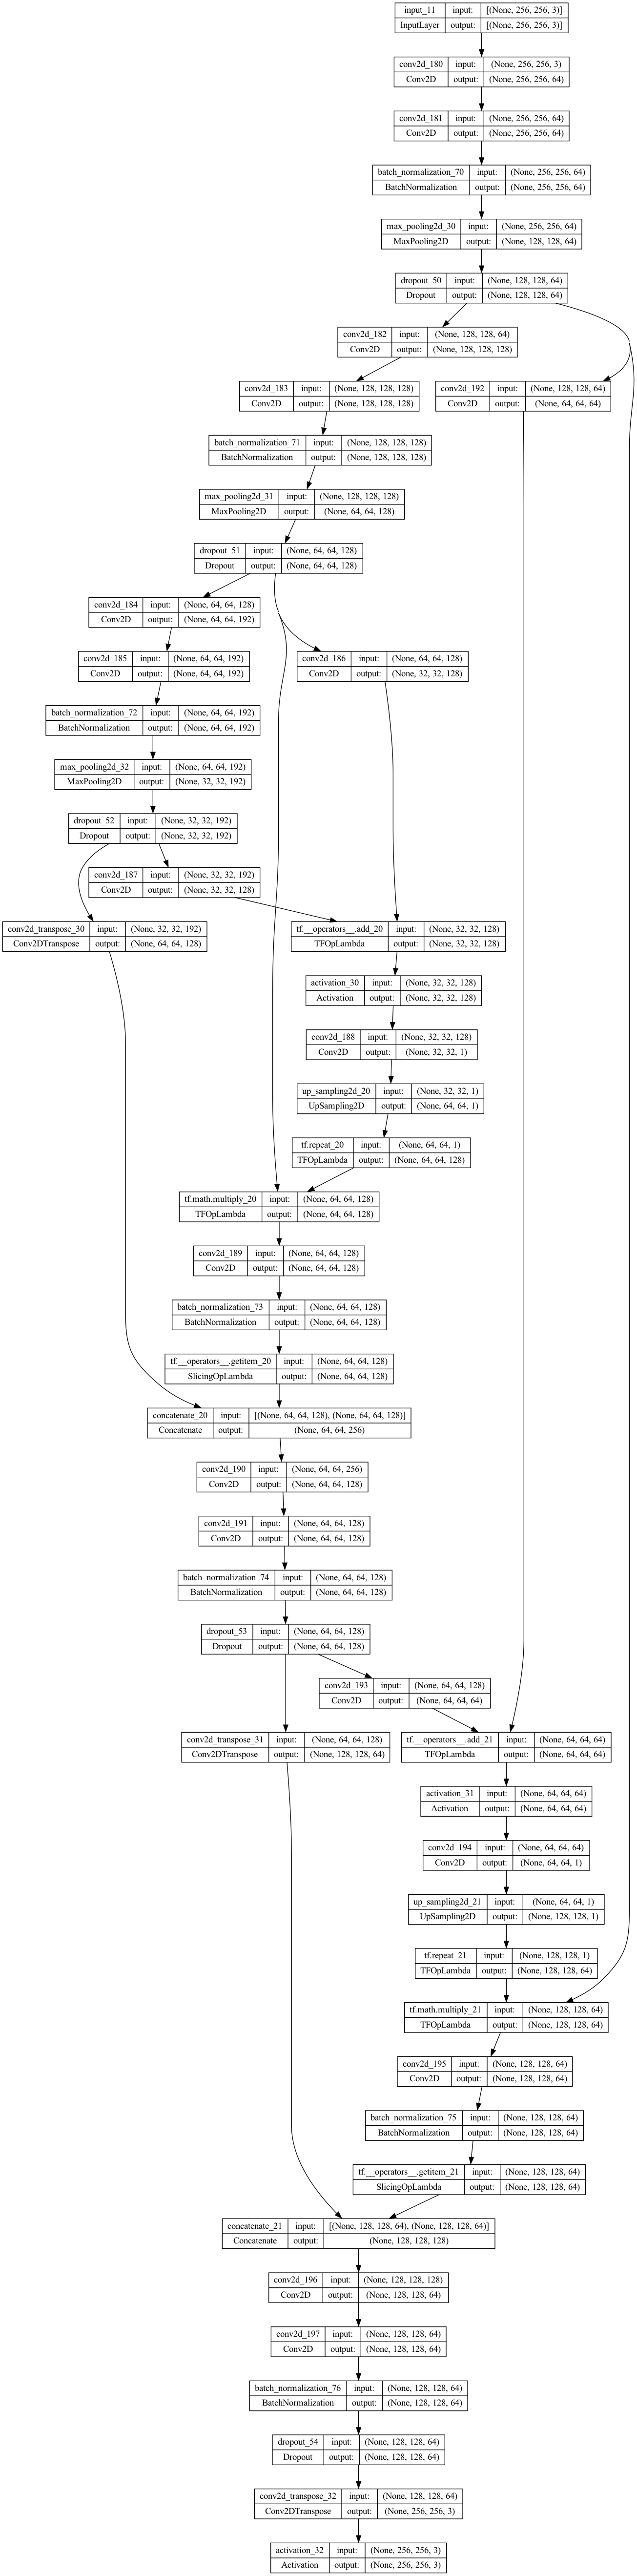

In [337]:
N_ENCODERS = 2
# LEARNING_RATE = 0.0003
LEARNING_RATE = 0.001
STEPS_PER_EPOCH = 805

def resize_block(input):
    conv_transpose = layers.Conv2DTranspose(
        2 + 1, 3, strides=(2, 2), padding='same')(input)

    # normalization = layers.Normalization()(conv_transpose)
    output = layers.Activation('sigmoid')(conv_transpose)
                                    
    return output

def create_model():
    inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))

    encoder_blocks = list(accumulate([inp] + list(range(1, N_ENCODERS+1)), lambda x,
                                     idx: encoder_block(x, idx, name='ENC_BLOCK_{}'.format(idx))))

    # Remove the initial input from the list of encoder blocks
    encoder_blocks.pop(0)

    # Create the mid block. It is kept separate from the encoder blocks
    # because it doesn't have a corresponding decoder block.
    mid_block = encoder_block(
        encoder_blocks[-1], N_ENCODERS+1, name='MID_BLOCK')

    decoder_blocks = list(accumulate([mid_block] + list(enumerate(reversed(encoder_blocks))), lambda x, item: decoder_block(
        x, item[1], N_ENCODERS - item[0], 'DEC_BLOCK_{}'.format(item[0]+1))))

    # Remove the mid block from the list of decoder blocks
    decoder_blocks.pop(0)

    output = resize_block(decoder_blocks[-1])
    m = tf.keras.Model(inputs=inp, outputs=output)
    lr_schedule = optimizers.schedules.InverseTimeDecay(
        LEARNING_RATE,
        decay_steps=STEPS_PER_EPOCH*5,
        decay_rate=0.75,
        staircase=False)
    optimizer = optimizers.Adam(lr_schedule)
    loss = compute_hw_loss
    metrics = []
    m.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return m


model = create_model()
model.summary()

utils.plot_model(model, show_shapes=True)

- [x] Custom training loop to efficiently calculate and emit multiple loss metrics.
- [x] Checkpoints
- [x] Emit box and non-box losses separately. 

In [338]:
@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss, box_loss, non_box_loss = model.loss(y, logits)

    # Compute gradients and backpropagate.
    grads = tape.gradient(loss, model.trainable_weights)
    model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss, box_loss, non_box_loss, logits

@tf.function
def val_step(model, x, y):
    logits = model(x, training=False)
    loss, box_loss, non_box_loss = model.loss(y, logits)
    
    return loss, box_loss, non_box_loss, logits

def auto_train(model, tds, vds, epochs=100, callbacks=[]):
    # tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    # vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE).take(1) if vds else None
    
    # tf.profiler.experimental.start('logdir')
    history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)
    # tf.profiler.experimental.stop()

    return history

def train(model, tds, vds, epochs=100):
    # Record progress
    ckpt = tf.train.Checkpoint(optimizer=model.optimizer, model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, './attention_unet_od', max_to_keep=3)
    history = History()
    
    # tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    # vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE).take(2)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE).take(2) if vds else None

    for epoch in range(epochs):
        # Track training progress
        print("\nEpoch {}/{}".format(epoch + 1, epochs))
        p_bar = utils.Progbar(STEPS_PER_EPOCH, stateful_metrics=history.metric_names)
        steps = 0

        for step, (x, y) in enumerate(iter(tds)):
            loss, box_loss, non_box_loss, logits = train_step(model, x, y)
            # _, _, iou = evaluate_predictions(y, logits)
            iou = 0.

            p_bar.update(step + 1, values=history.train_step(loss, box_loss, non_box_loss, iou))
            steps += 1
        
        for x, y in iter(vds):
            loss, box_loss, non_box_loss, logits = val_step(model, x, y)
            # _, _, iou = evaluate_predictions(y, logits)
            iou = 0.

            history.val_step(loss, box_loss, non_box_loss, iou)
        
        # Display metrics at the end of each epoch.
        p_bar.update(steps, values=history.epoch())

        # Save Checkpoint
        print('\nSaved Checkpoint: {}'.format(ckpt_manager.save()))


    return history

EPOCHS = 2
# EPOCHS = 50
BATCH_SIZE = 2

tds = train_prep_ds.shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
# vds = val_prep_ds.batch(256).cache()
vds = val_prep_ds.batch(2).cache()

hist = train(model, tds, vds, epochs=EPOCHS)
hist.history


Epoch 1/2


2023-04-22 15:56:30.525072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  2/805 [..............................] - ETA: 13:55 - loss: 1.8486 - box_loss: 0.8538 - non_box_loss: 0.9949 - iou: 0.0000e+00  

2023-04-22 15:56:35.726039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  2/805 [..............................] - ETA: 29:03 - loss: 1.8486 - box_loss: 0.8538 - non_box_loss: 0.9949 - iou: 0.0000e+00 - val_loss: 1.8758 - val_box_loss: 0.8784 - val_non_box_loss: 0.9974 - val_iou: 0.0000e+00

2023-04-22 15:56:36.464863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Saved Checkpoint: ./attention_unet_od/ckpt-1

Epoch 2/2
  2/805 [..............................] - ETA: 15:25 - loss: 1.8980 - box_loss: 0.9072 - non_box_loss: 0.9908 - iou: 0.0000e+00 - val_loss: 1.8704 - val_box_loss: 0.8757 - val_non_box_loss: 0.9948 - val_iou: 0.0000e+00
Saved Checkpoint: ./attention_unet_od/ckpt-2


2023-04-22 15:56:39.915733: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'loss': [1.8486362, 1.89801],
 'val_loss': [1.8758168, 1.8704476],
 'box_loss': [0.8537855, 0.9072023],
 'val_box_loss': [0.87841415, 0.8756933],
 'non_box_loss': [0.99485064, 0.9908078],
 'val_non_box_loss': [0.99740255, 0.9947543],
 'iou': [0.0, 0.0],
 'val_iou': [0.0, 0.0]}

In [339]:

# create callback
# use AIP_TENSORBOARD_LOG_DIR to update where logs are written
# tensorboard_cb = cbs.TensorBoard(log_dir='logdir')
# checkpoint_name_tmpl = 'weights-epoch-{epoch:d}-val_loss-{val_loss:.4f}.h5'
# checkpoint_name_tmpl = 'weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
# checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_loss")

EPOCHS = 2
# EPOCHS = 50
BATCH_SIZE = 2

# callbacks = [checkpoint, tensorboard_cb]
# callbacks = [checkpoint]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
# vds = val_prep_ds.batch(256).cache()
vds = val_prep_ds.batch(2).cache()

hist = train(model, tds, vds, epochs=EPOCHS)

with open('training.results.pkl', 'wb') as f:
    pickle.dump(hist.history, f)


Epoch 1/2
  2/805 [..............................] - ETA: 13:59 - loss: 2.0192 - box_loss: 1.0325 - non_box_loss: 0.9867 - iou: 0.0000e+00 - val_loss: 1.8654 - val_box_loss: 0.8731 - val_non_box_loss: 0.9923 - val_iou: 0.0000e+00

2023-04-22 15:56:43.112046: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Saved Checkpoint: ./attention_unet_od/ckpt-1

Epoch 2/2
  2/805 [..............................] - ETA: 12:28 - loss: 1.8224 - box_loss: 0.8377 - non_box_loss: 0.9848 - iou: 0.0000e+00 - val_loss: 1.8606 - val_box_loss: 0.8706 - val_non_box_loss: 0.9900 - val_iou: 0.0000e+00
Saved Checkpoint: ./attention_unet_od/ckpt-2


2023-04-22 15:56:44.803730: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'loss': [2.01919, 1.8224462],
 'val_loss': [1.8653953, 1.8605962],
 'box_loss': [1.0325282, 0.837675],
 'val_box_loss': [0.8730825, 0.8705661],
 'non_box_loss': [0.9866619, 0.98477125],
 'val_non_box_loss': [0.9923128, 0.99003],
 'iou': [0.0, 0.0],
 'val_iou': [0.0, 0.0]}

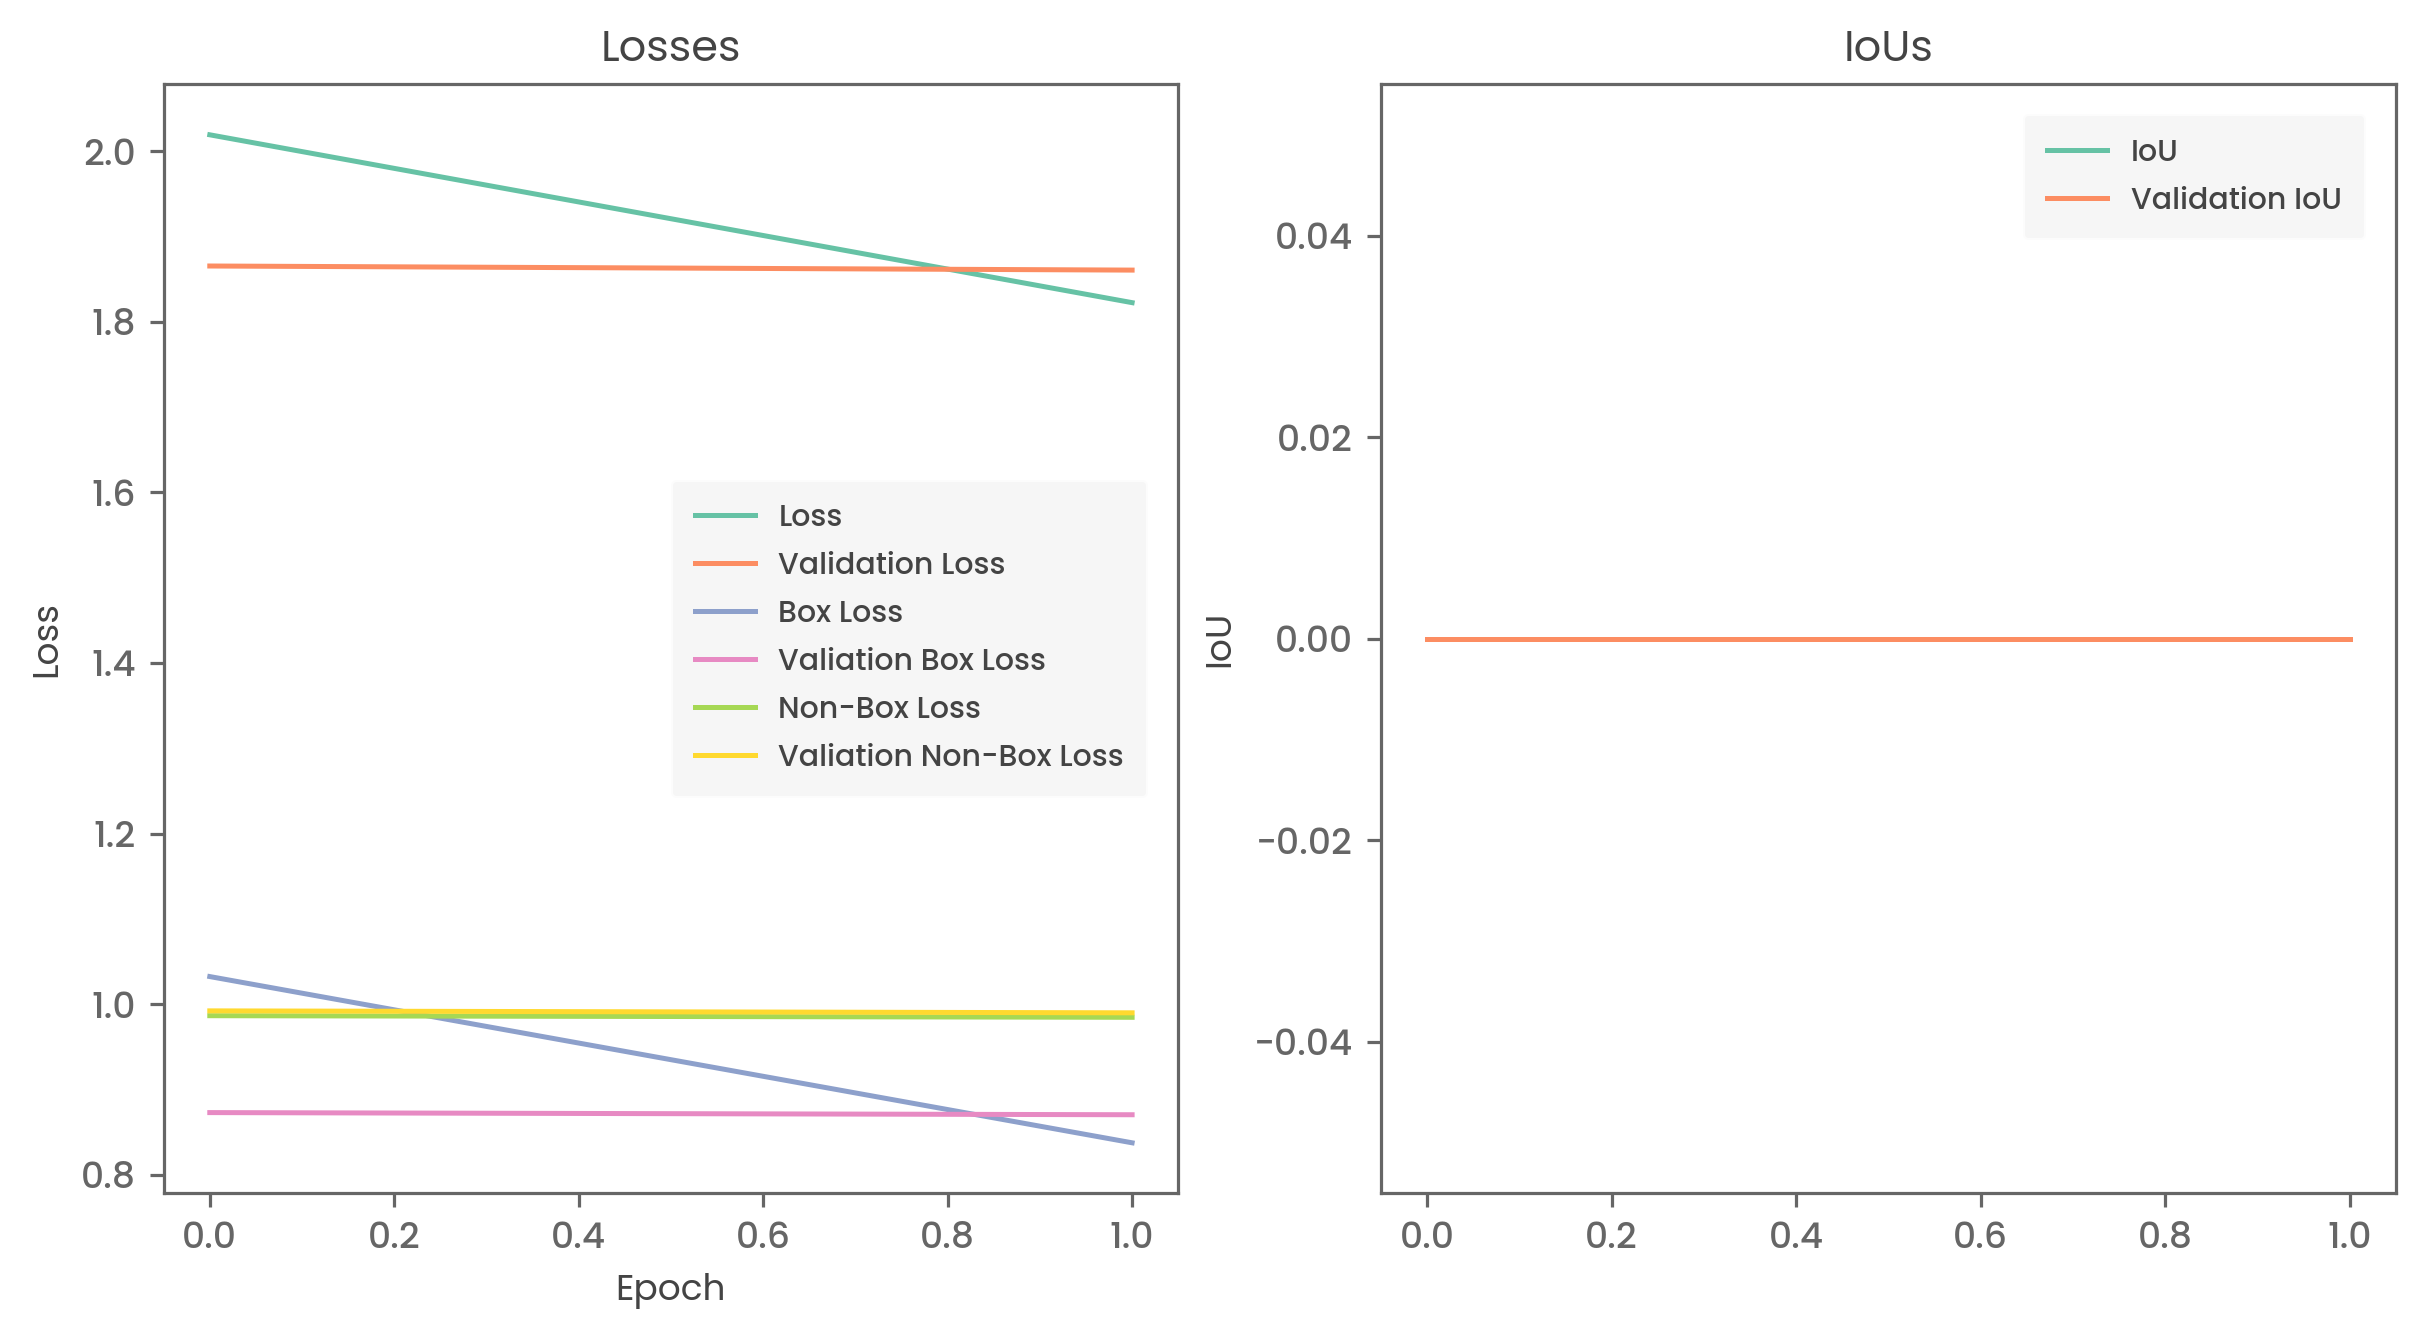

In [340]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    loss_axes, iou_axes = axes

    loss_axes.plot(h['loss'], label='Loss')
    loss_axes.plot(h['val_loss'], label='Validation Loss')

    loss_axes.plot(h['box_loss'], label='Box Loss')
    loss_axes.plot(h['val_box_loss'], label='Valiation Box Loss')

    loss_axes.plot(h['non_box_loss'], label='Non-Box Loss')
    loss_axes.plot(h['val_non_box_loss'], label='Valiation Non-Box Loss')

    loss_axes.set_xlabel('Epoch')
    loss_axes.set_ylabel('Loss')
    loss_axes.set_title('Losses')
    loss_axes.legend()

    iou_axes.plot(h['iou'], label='IoU')
    iou_axes.plot(h['val_iou'], label='Validation IoU')

    iou_axes.set_ylabel('IoU')
    iou_axes.set_title('IoUs')
    iou_axes.legend()

plot_history(hist.history)
hist.history

## Model Evaluation

### Evaluation on Validation Data

In [341]:
ds = val_ds.filter(filter_empty_bboxes).map(preprocess)
itr = iter(ds.batch(2))
images, y_true = next(itr)
y_pred = model(images)

yxhw_true:  [[[0.472496, 0.887695, 0.118477, 0.063477], [0.263752, 0.767578, 0.146685, 0.074219], [0.324401, 0.701172, 0.115656, 0.057617], ..., [0.214386, 0.294922, 0.135402, 0.064453], [0.191819, 0.173828, 0.152327, 0.077148], [0.057828, 0.509766, 0.101551, 0.056641]], [[0.798959, 0.534180, 0.068315, 0.137695]]] TensorShape([2, None, None])
yxhw_preds:  [[[0.47249648 0.887695312 0.490687966 0.489987969]
 [0.263751775 0.767578125 0.492074251 0.499008715]
 [0.324400574 0.701171875 0.490270227 0.492867]
 ...
 [0.214386463 0.294921875 0.495502174 0.498104334]
 [0.191819459 0.173828125 0.491097897 0.49001798]
 [0.0578279272 0.509765625 0.495130032 0.4968701]], [[0.798959 0.534179688 0.499393553 0.496809691]]] [2, 8, 4]


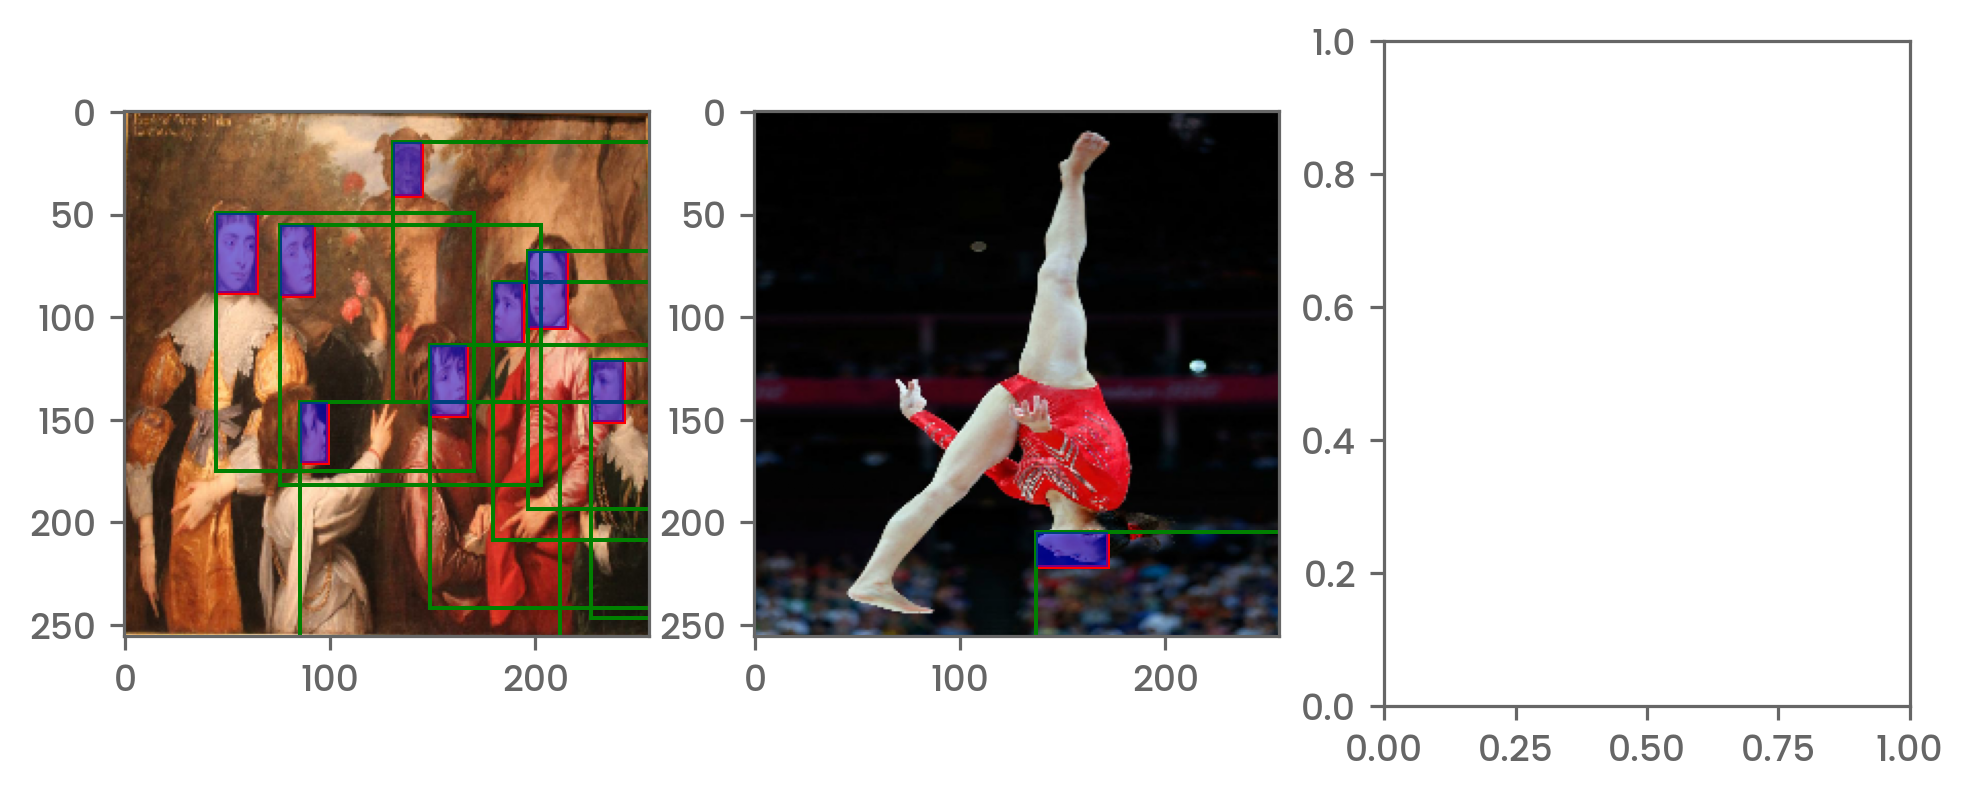

In [342]:
def plot_boxes(ax, boxes, size, color='green', alpha=1.0, fill=False, no_edge=False):
    """
        ax: Plot Axes.
        grid: A grid of YXHW values for each pixel. Shape: (IMG_SIZE, IMG_SIZE, 4)
        indices: Indices of valid boxes. Shape: (N_BOXES, 3)
        size: The size of the container.
        color: Box fill color
    """
    boxes = boxes*size
    # tf.print(boxes)

    for box in boxes:
        [y_min, x_min, height, width] = box
        rect_patch = patches.Rectangle([x_min, y_min], width, height, ec=None if no_edge else color, fill=fill, fc=color, alpha=alpha)
        ax.add_patch(rect_patch)
        
def plot_comparisons(images, yxhw_true, yxhw_preds, yxhw_intersections, cols=3):
    batch_size = yxhw_true.shape[0]

    # Plot configuration
    rows = (batch_size + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(8, rows*3))
    color_1, color_2, color_i = ['red', 'green', 'blue']
    axes = axes.ravel()

    for item_id in range(batch_size):
        # Plot image
        axes[item_id].imshow(images[item_id])

        # Plot bounding boxes on an inverted axis to align with the image.
        plot_boxes(axes[item_id], yxhw_true[item_id], IMG_SIZE, color_1)
        plot_boxes(axes[item_id], yxhw_preds[item_id], IMG_SIZE, color_2)
        plot_boxes(axes[item_id], yxhw_intersections[item_id], IMG_SIZE, color_i, fill=True, alpha=0.5, no_edge=True)

yxhw_preds, yxhw_intersections, _ = evaluate_predictions(y_true, y_pred)
yxhw_true = yxyx_to_yxhw(y_true)
plot_comparisons(images, yxhw_true, yxhw_preds, yxhw_intersections)

tf.print('yxhw_true: ', yxhw_true, yxhw_true.shape)
tf.print('yxhw_preds: ', yxhw_preds, [len(yxhw_preds)] + yxhw_preds[0].shape.as_list())

### Evaluation on Test Data

In [343]:
ds = test_ds.map(preprocess)
itr = iter(ds.batch(2))
images, y_true = next(itr)
y_pred = model(images)

hw_predictions:  [[[[0.494741529 0.494735718]
   [0.497642 0.49527514]
   [0.491279244 0.491716802]
   ...
   [0.496849597 0.495932311]
   [0.490612477 0.492157847]
   [0.497800291 0.494232029]]

  [[0.498944849 0.500992417]
   [0.490712345 0.496972173]
   [0.4982135 0.495186388]
   ...
   [0.489874333 0.495985]
   [0.496804893 0.49614045]
   [0.489039719 0.496225059]]

  [[0.494725436 0.494309843]
   [0.493633121 0.495713115]
   [0.488783717 0.489168167]
   ...
   [0.492993921 0.496955812]
   [0.48901397 0.488130301]
   [0.494340122 0.496622175]]

  ...

  [[0.497523248 0.4997136]
   [0.491387 0.496921897]
   [0.498415619 0.496615052]
   ...
   [0.494273722 0.495928794]
   [0.495867491 0.496486247]
   [0.49022463 0.496791]]

  [[0.493936598 0.495277971]
   [0.497378051 0.496185184]
   [0.48794353 0.490411]
   ...
   [0.496398062 0.496969223]
   [0.491373241 0.493037432]
   [0.494459242 0.495779037]]

  [[0.498028219 0.499715]
   [0.491253883 0.49586302]
   [0.498553425 0.496372104]
  

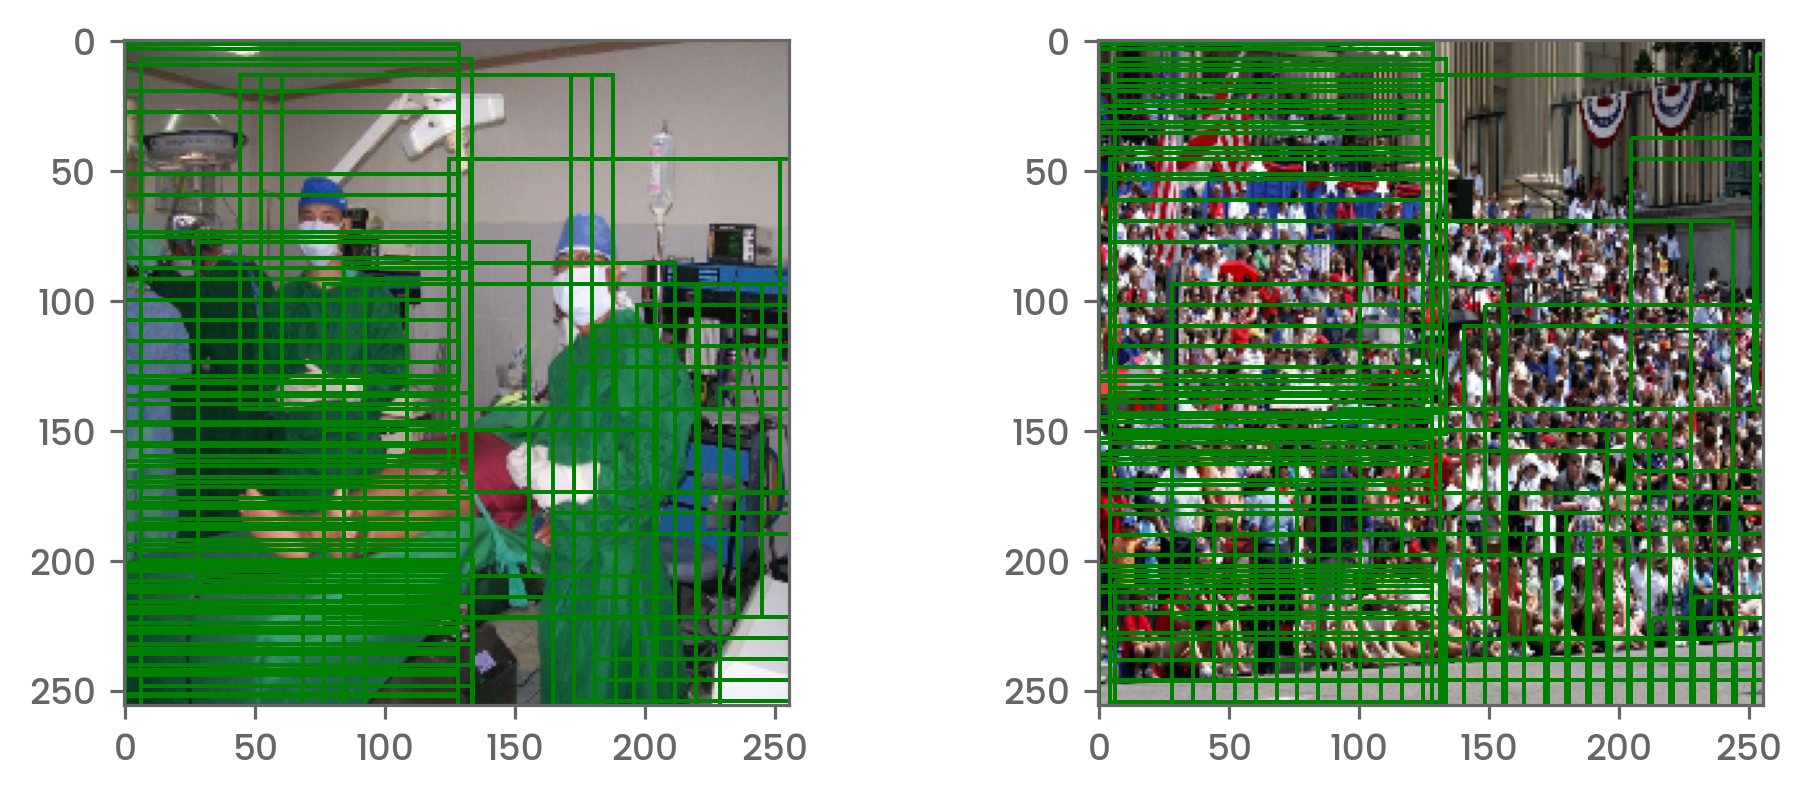

In [344]:
def plot_predictions(images, cols=2, num_boxes=100):
    batch_size = images.shape[0]

    # Get HW predictions for each grid pixel
    predictions = model(images)
    hw_predictions = predictions[:, :, :, 0:2]
    mean_hw_predictions = tf.math.reduce_mean(hw_predictions, axis=-1)

    tf.print('hw_predictions: ', hw_predictions, hw_predictions.shape)
    tf.print('mean_hw_predictions: ', mean_hw_predictions, mean_hw_predictions.shape)

    # Compute H+W for each box. This value is used to select the biggest predicted boxes.
    size_predictions = tf.math.reduce_sum(hw_predictions, axis=-1)

    # tf.print('hw_predictions: ', hw_predictions, hw_predictions.shape)
    # tf.print('size_predictions: ', size_predictions, size_predictions.shape)

    biggest_sizes = tf.math.top_k(tf.reshape(size_predictions, [batch_size, -1]), k=num_boxes)

    # tf.print('biggest_sizes.indices: ', biggest_sizes.indices, biggest_sizes.indices.shape)
    # tf.print('biggest_sizes.values: ', biggest_sizes.values, biggest_sizes.values.shape)

    # Plot configuration
    rows = (batch_size + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(8, rows*3))
    color_1, color_2, color_i = ['red', 'green', 'blue']
    axes = axes.ravel()

    for item_id in range(batch_size):
        yx_indices = tf.transpose(tf.unravel_index(indices=biggest_sizes.indices[item_id], dims=size_predictions.shape[1:]))
        yx_boxes = tf.cast(yx_indices / (IMG_SIZE - 1), dtype=tf.float32)

        # tf.print('yx_indices: ', yx_indices, yx_indices.shape)
        # tf.print('yx_boxes: ', yx_boxes, yx_boxes.shape)

        hw_boxes = tf.gather_nd(hw_predictions[item_id], yx_indices)
        boxes = tf.concat([yx_boxes, hw_boxes], axis=-1)

        # tf.print('hw_boxes: ', hw_boxes, hw_boxes.shape)
        # tf.print('boxes: ', boxes, boxes.shape)
        
        # for box_id in range(5):
        #     h, w = biggest_predictions[box_id]
        #     tf.print('hw_predictions[][]: ', biggest_sizes.indices[item_id][box_id], h, w, boxes[box_id] == hw_predictions[item_id][h][w])

        axes[item_id].imshow(images[item_id])
        plot_boxes(axes[item_id], boxes, IMG_SIZE)

plot_predictions(images)

In [345]:
# t = tf.constant([768, 64769, 65280, 65290])
# tf.transpose(tf.unravel_index(t, dims=[256, 256]))

# t = tf.random.uniform((256, 256, 2))
# tf.gather_nd(t, tf.constant([[100, 100], [150, 150], [200, 200]])), t[100][100], t[200][200]